In [ ]:
from google.colab import files
from IPython.display import Image

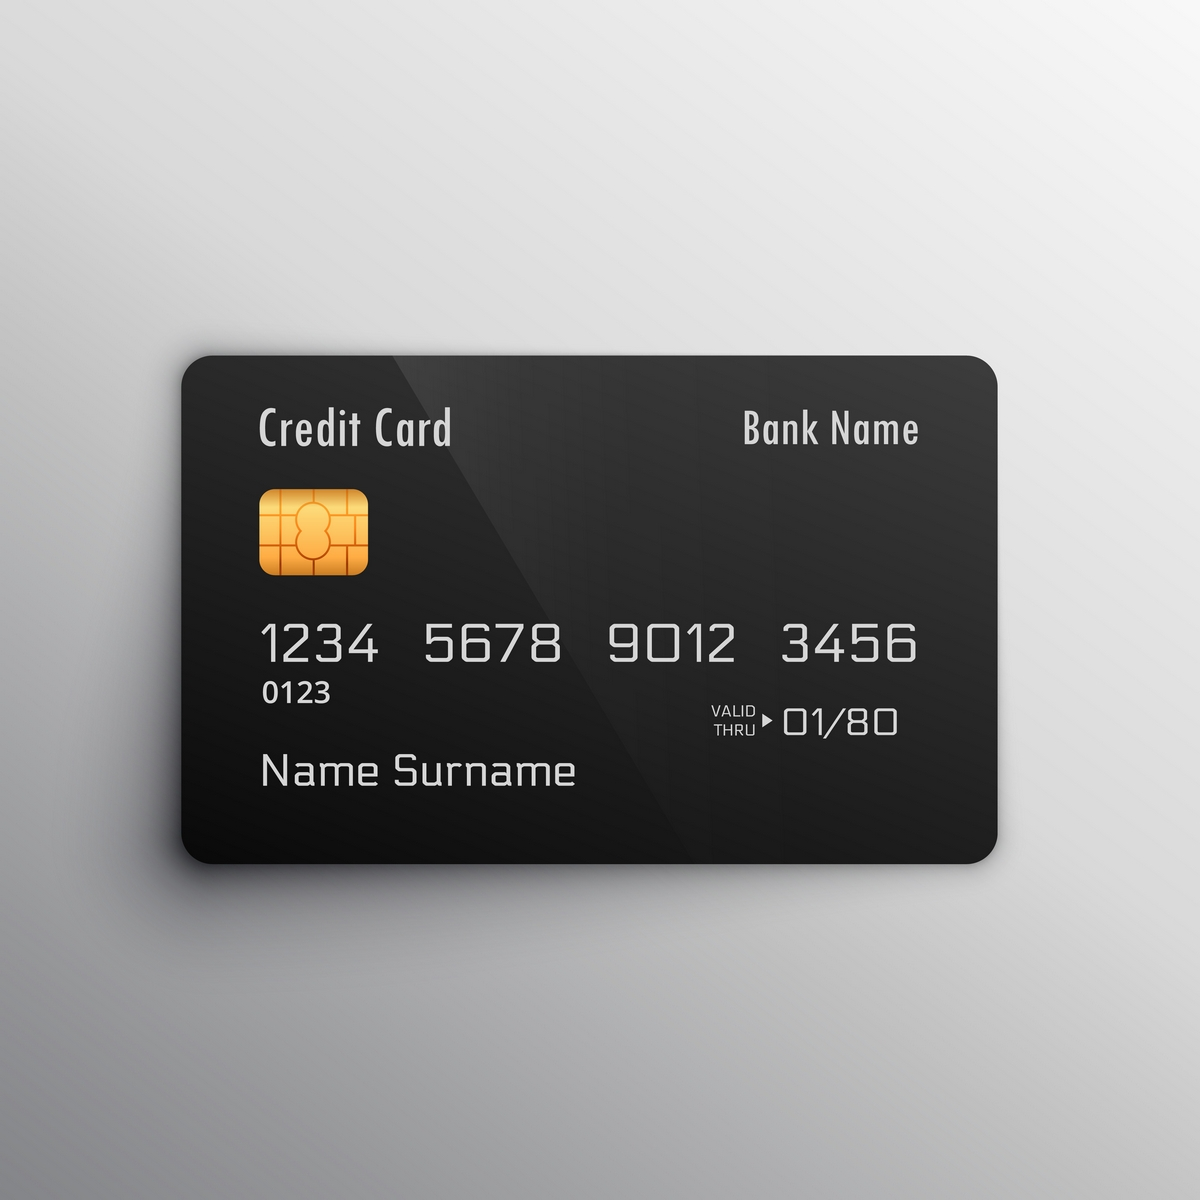

In [ ]:
Image('/content/6276.jpg',width=725)

In [ ]:
import warnings, os, json, math, sys
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from IPython.display import display

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, auc,
    f1_score, precision_score, recall_score, confusion_matrix, brier_score_loss
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
sns.set_context("notebook")
plt.rcParams["figure.figsize"]=(10,5)

SEED = 42
np.random.seed(SEED)

# Business cost assumptions (tune as needed)
COST_FP = 5.0     # investigation cost per false alert
COST_FN = 200.0   # average loss per missed fraud

Load Datasets

In [4]:
df=pd.read_csv('/content/creditcard.csv')

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41683 entries, 0 to 41682
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    41683 non-null  int64  
 1   V1      41683 non-null  float64
 2   V2      41683 non-null  float64
 3   V3      41682 non-null  float64
 4   V4      41682 non-null  float64
 5   V5      41682 non-null  float64
 6   V6      41682 non-null  float64
 7   V7      41682 non-null  float64
 8   V8      41682 non-null  float64
 9   V9      41682 non-null  float64
 10  V10     41682 non-null  float64
 11  V11     41682 non-null  float64
 12  V12     41682 non-null  float64
 13  V13     41682 non-null  float64
 14  V14     41682 non-null  float64
 15  V15     41682 non-null  float64
 16  V16     41682 non-null  float64
 17  V17     41682 non-null  float64
 18  V18     41682 non-null  float64
 19  V19     41682 non-null  float64
 20  V20     41682 non-null  float64
 21  V21     41682 non-null  float64
 22

In [7]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Time,41683.0,26208.345609,12721.514541,0.000000,16853.000000,31305.000000,36289.000000,40784.000000
V1,41683.0,-0.222499,1.855101,-56.407510,-0.974000,-0.240189,1.159396,1.960497
V2,41683.0,0.035454,1.599923,-72.715728,-0.533197,0.093834,0.740067,16.713389
V3,41682.0,0.711902,1.490121,-31.103685,0.229759,0.811276,1.443056,4.101716
V4,41682.0,0.186781,1.399707,-5.172595,-0.719018,0.185168,1.069459,16.491217
V5,41682.0,-0.234719,1.387375,-42.147898,-0.842162,-0.272258,0.293052,34.801666
V6,41682.0,0.099510,1.309662,-26.160506,-0.638071,-0.156277,0.485883,22.529298
V7,41682.0,-0.112246,1.238350,-26.548144,-0.598424,-0.073482,0.432308,36.677268
V8,41682.0,0.044579,1.209428,-41.484823,-0.151197,0.050183,0.318625,20.007208
V9,41682.0,0.193708,1.220092,-7.175097,-0.568666,0.071496,0.906980,10.392889


In [8]:
print("Shape:", df.shape)

Shape: (41683, 31)


Data Cleaning

In [9]:
print(df.columns.tolist())

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


Check missing values

In [10]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 Time      0
V1        0
V2        0
V3        1
V4        1
V5        1
V6        1
V7        1
V8        1
V9        1
V10       1
V11       1
V12       1
V13       1
V14       1
V15       1
V16       1
V17       1
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64


In [11]:
df=df.dropna()

In [12]:
print("Duplicates:", df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)

Duplicates: 181


Feature Enginerring

In [13]:
# Time-derived proxies (Time = seconds-from-start, not real timestamps)

df['Hour_from_start_mod24'] = ((df['Time'] // 3600) % 24).astype(int)
df['is_night_proxy'] = df['Hour_from_start_mod24'].isin([22,23,0,1,2,3,4,5]).astype(int)
df['is_business_hours_proxy'] = df['Hour_from_start_mod24'].between(9,17).astype(int)

df['_log_amount'] = np.log1p(df['Amount'])


features = [c for c in df.columns if c.startswith("V")] + [
    'Amount','_log_amount',
    'Hour_from_start_mod24','is_night_proxy','is_business_hours_proxy'
]
target = "Class"

Explaotary Data Analysis (EDA)

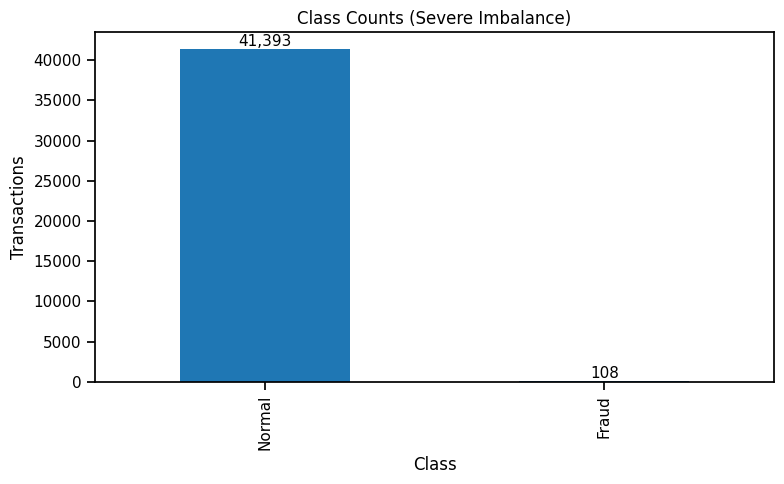

In [14]:
counts = df['Class'].value_counts().rename({0:'Normal', 1:'Fraud'})
fig, ax = plt.subplots(figsize=(8,5))
counts.plot(kind='bar', ax=ax)
for i, v in enumerate(counts.values):
    ax.text(i, v, f"{v:,}", ha='center', va='bottom', fontsize=11)
ax.set_title('Class Counts (Severe Imbalance)')
ax.set_ylabel('Transactions'); ax.set_xlabel('Class')
plt.tight_layout()
plt.show()

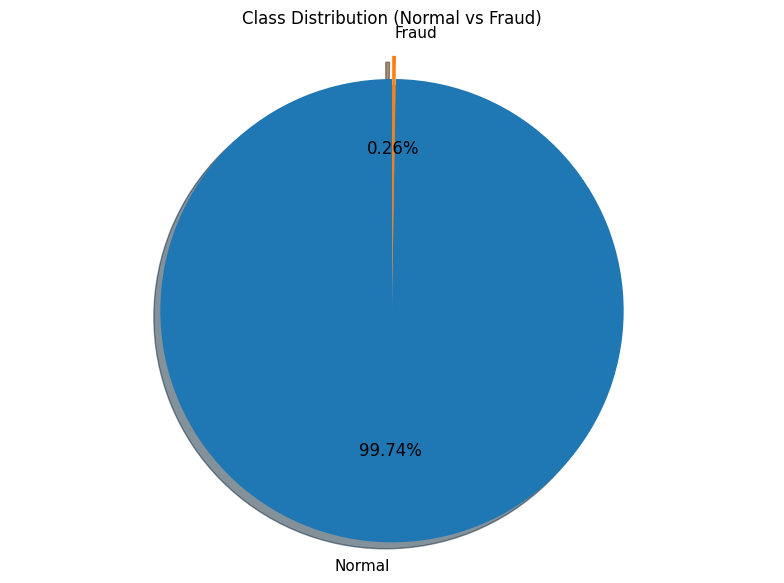

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.pie(counts.values, labels=counts.index, autopct='%1.2f%%', startangle=90, explode=[0,0.1], shadow=True)
ax.set_title('Class Distribution (Normal vs Fraud)')
ax.axis('equal')
plt.tight_layout()
plt.show()

Amount distribution

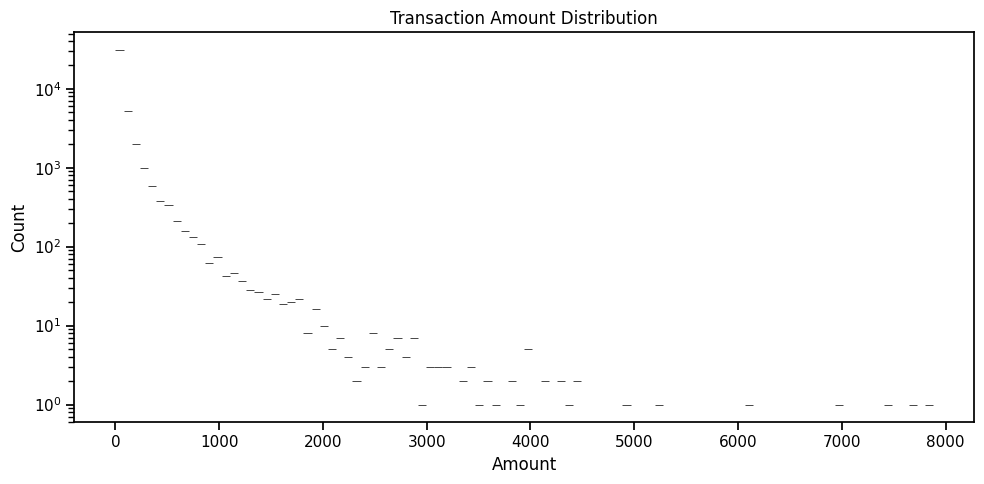

In [17]:
sns.histplot(df["Amount"], bins=100, log_scale=(False, True))
plt.title("Transaction Amount Distribution")
plt.tight_layout()
plt.show()

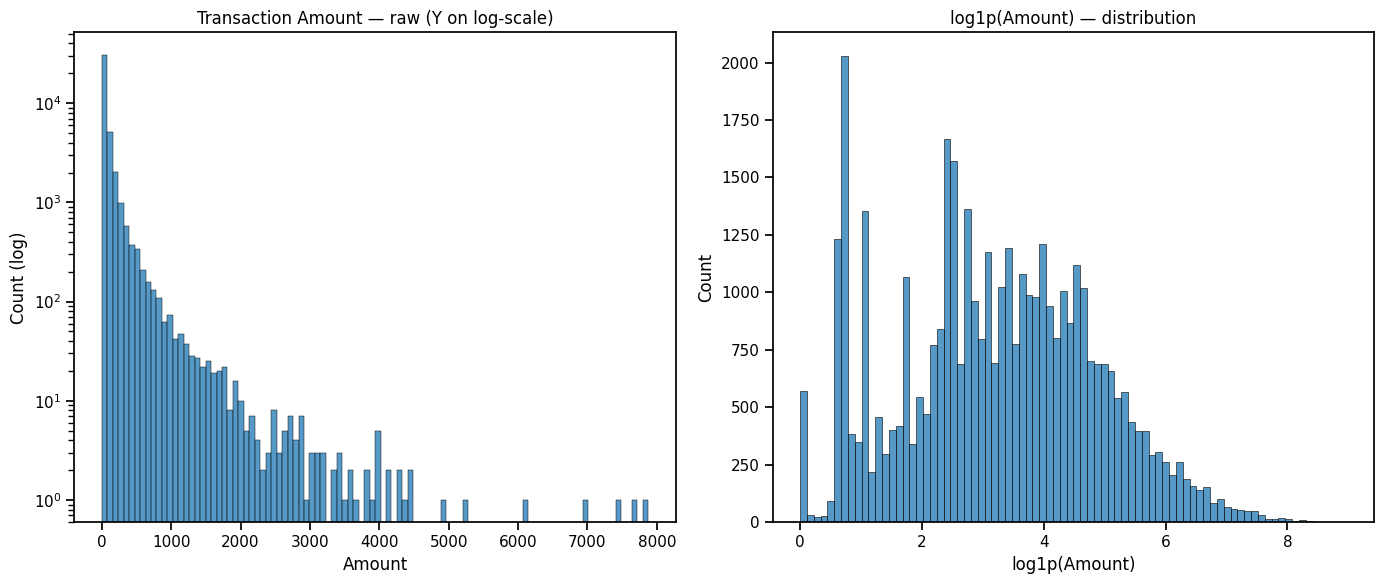

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Raw amount, log-scaled Y
sns.histplot(df["Amount"], bins=100, ax=axes[0])
axes[0].set_yscale("log")
axes[0].set_title("Transaction Amount — raw (Y on log-scale)")
axes[0].set_xlabel("Amount")
axes[0].set_ylabel("Count (log)")

# Log-transformed feature on X
sns.histplot(df["_log_amount"], bins=80, ax=axes[1])
axes[1].set_title("log1p(Amount) — distribution")
axes[1].set_xlabel("log1p(Amount)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

Left: “Raw amount with a logarithmic Y-axis to reveal the long tail of transaction counts without altering the original magnitude on X.”¶

Right: “Distribution of log1p(Amount). The log transform reduces skewness and makes patterns easier to model and compare.”

Fraud Rate by Hour

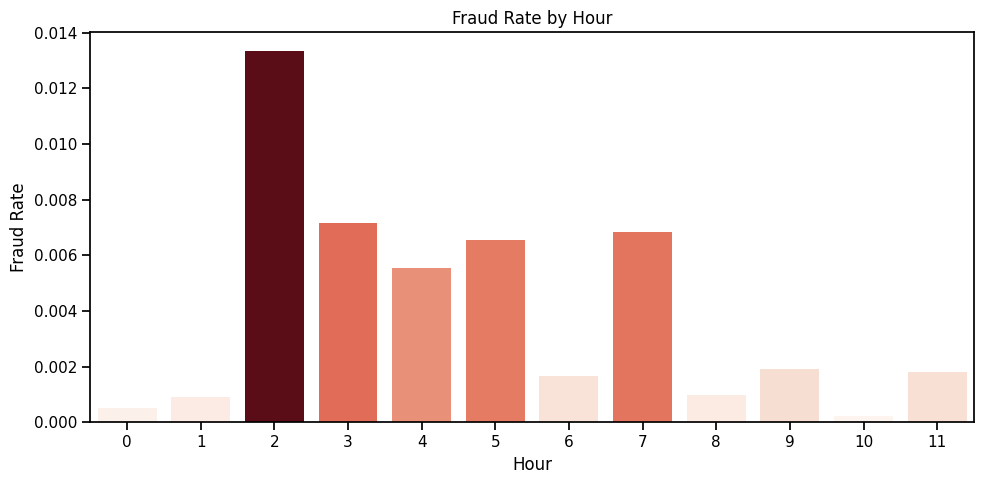

In [19]:
fraud_by_hour = df.groupby("Hour_from_start_mod24")["Class"].mean()

cmap = sns.color_palette("Reds", as_cmap=True)
vals = (fraud_by_hour / fraud_by_hour.max()).values
pal = [cmap(v) for v in vals]

sns.barplot(x=fraud_by_hour.index, y=fraud_by_hour.values, palette=pal)
plt.title("Fraud Rate by Hour")
plt.xlabel("Hour")
plt.ylabel("Fraud Rate")
plt.tight_layout()
plt.show()

Transactions per Hour

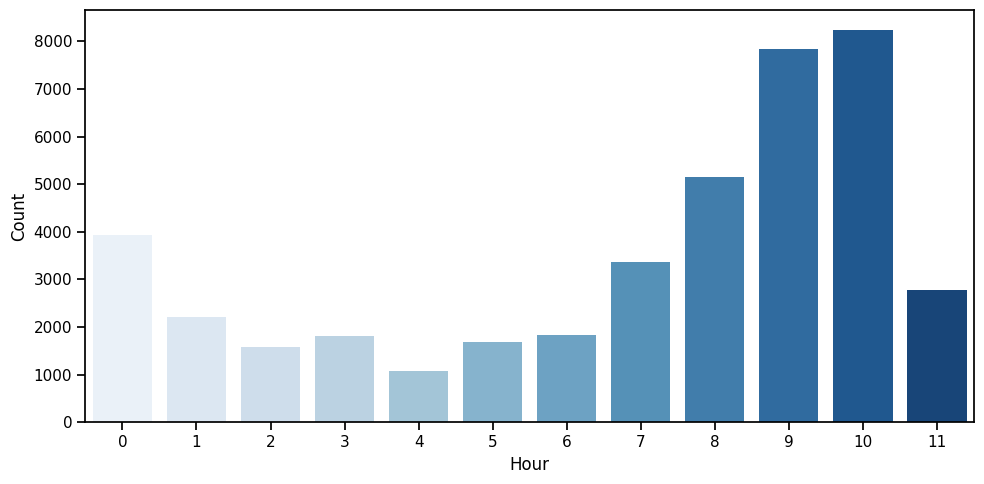

In [20]:
tx_by_hour = df.groupby("Hour_from_start_mod24")[target].count()
sns.barplot(x=tx_by_hour.index, y=tx_by_hour.values, palette='Blues')
plt.xlabel('Hour')
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Boxplot: Amount by Class

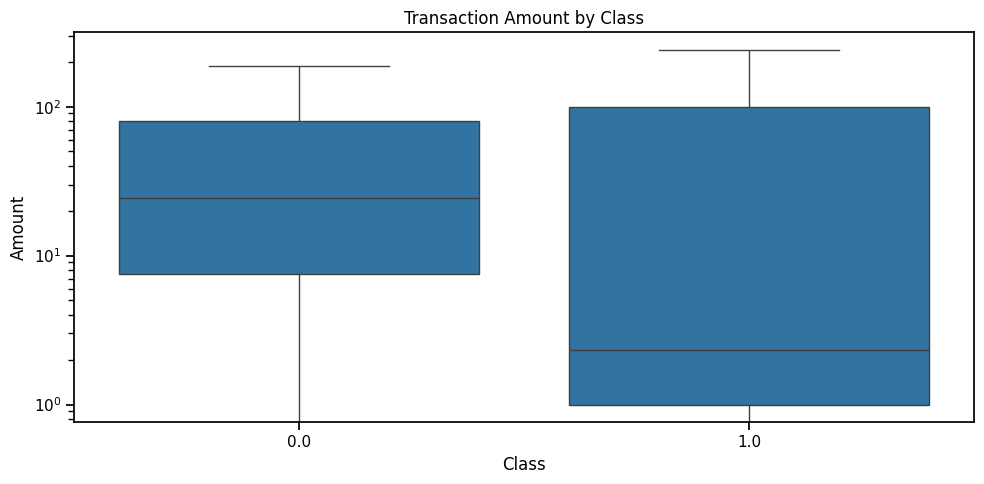

In [21]:
sns.boxplot(x= "Class", y="Amount" , data=df , showfliers=False)
plt.yscale("log")
plt.title("Transaction Amount by Class")
plt.tight_layout()
plt.show()

Amount deciles vs fraud rate

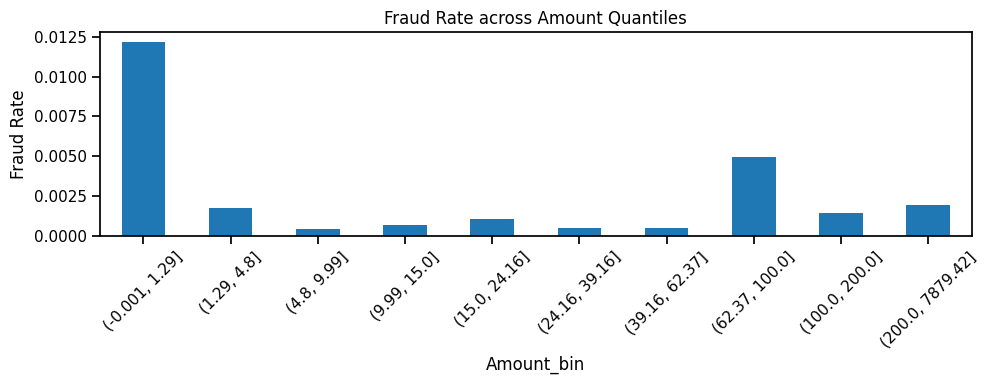

In [22]:
df["Amount_bin"] = pd.qcut(df["Amount"], q=10, duplicates="drop")
fraud_rate_bins = df.groupby("Amount_bin")["Class"].mean()
fraud_rate_bins.plot(kind="bar", figsize=(10,4))
plt.title("Fraud Rate across Amount Quantiles")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Correlation matrix

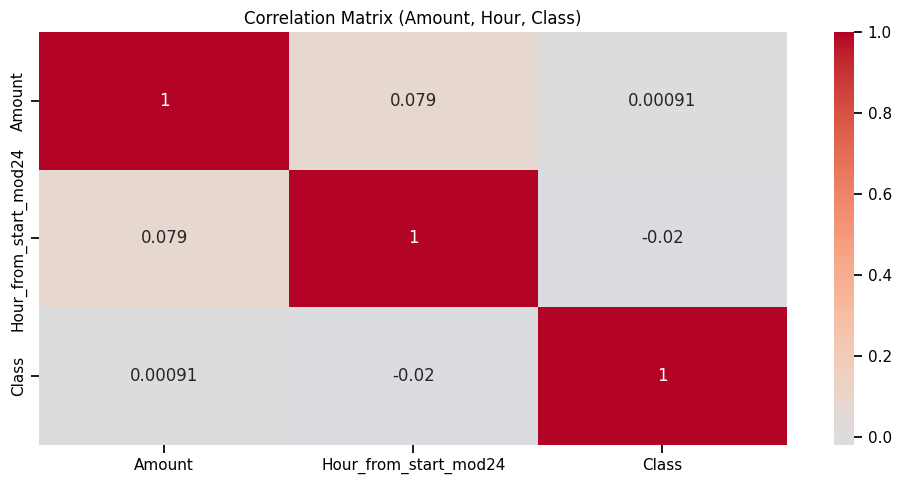

In [23]:
sns.heatmap(df[["Amount","Hour_from_start_mod24","Class"]].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Amount, Hour, Class)")
plt.tight_layout()
plt.show()

Time Segments (Morning / Afternoon / Evening / Night)

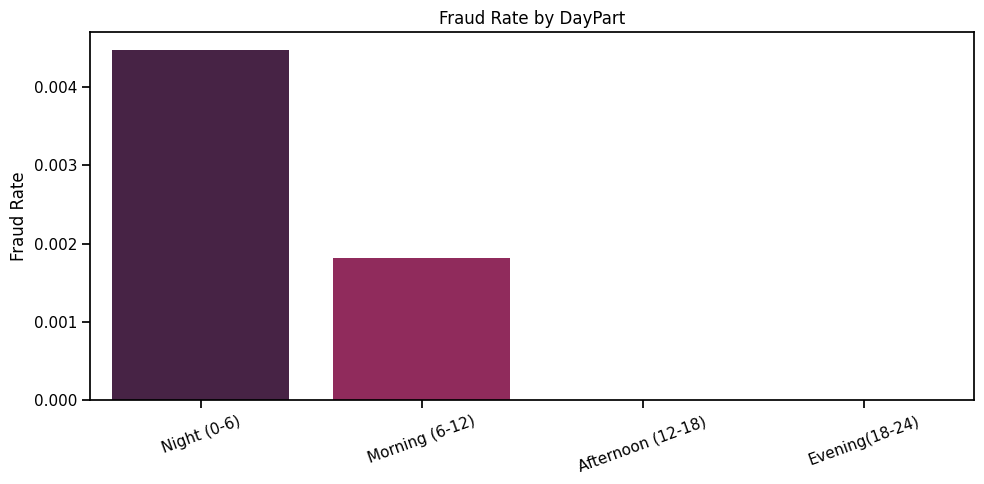

In [24]:
bins   = [0,6,12,18,24]
labels = ["Night (0-6)", "Morning (6-12)", "Afternoon (12-18)", "Evening(18-24)"]
df["DayPart"] = pd.cut(df["Hour_from_start_mod24"], bins=bins, labels=labels, right=False, include_lowest=True)


fraud_by_part  = df.groupby("DayPart")["Class"].mean().reindex(labels)

sns.barplot(x=fraud_by_part.index, y=fraud_by_part.values, palette="rocket")
plt.xticks(rotation=20)
plt.title("Fraud Rate by DayPart")
plt.xlabel("")
plt.ylabel("Fraud Rate")
plt.tight_layout()
plt.show()

Heatmap for Hour Rate

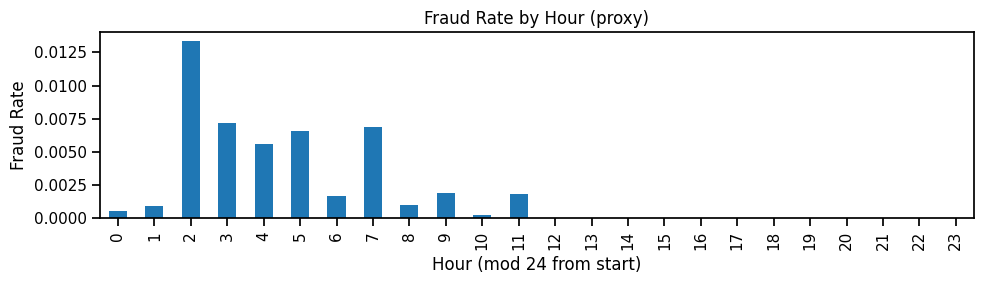

In [25]:
hour_rate = df.groupby("Hour_from_start_mod24")["Class"].mean().reindex(range(24)).fillna(0)
hour_rate.plot(kind="bar", figsize=(10,3), title="Fraud Rate by Hour (proxy)")
plt.xlabel("Hour (mod 24 from start)"); plt.ylabel("Fraud Rate")
plt.tight_layout(); plt.show()

Cumulative share of fraud by Amount rank

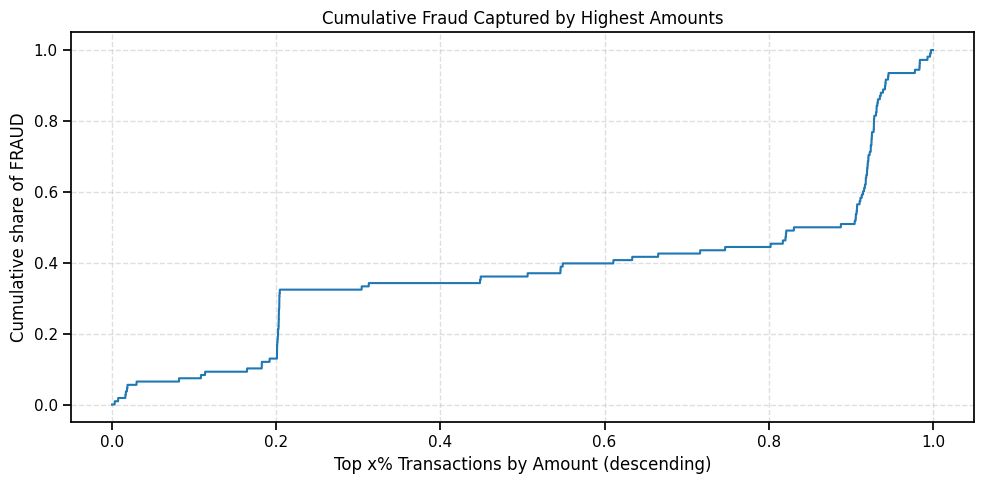

In [26]:
tmp = df[["Amount","Class"]].sort_values("Amount", ascending=False).reset_index(drop=True)
tmp["cum_tx"] = np.arange(1, len(tmp)+1) / len(tmp)
tmp["cum_fraud"] = tmp["Class"].cumsum() / tmp["Class"].sum()

plt.plot(tmp["cum_tx"], tmp["cum_fraud"])
plt.xlabel("Top x% Transactions by Amount (descending)")
plt.ylabel("Cumulative share of FRAUD")
plt.title("Cumulative Fraud Captured by Highest Amounts")
plt.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [27]:
df_sorted = df.sort_values("Time").reset_index(drop=True)
cut = int(0.8 * len(df_sorted))
train_df, test_df = df_sorted.iloc[:cut], df_sorted.iloc[cut:]

# Inner validation from train (time-ordered)
cut_in = int(0.8 * len(train_df))
train__df, val_df = train_df.iloc[:cut_in], train_df.iloc[cut_in:]

X_train , y_train = train__df[features], train__df[target].astype(int)
X_val   , y_val   = val_df[features]  , val_df[target].astype(int)
X_test  , y_test  = test_df[features] , test_df[target].astype(int)

print("Inner-Train:", len(X_train), "| Val:", len(X_val), "| Test:", len(X_test))
print("Train prevalence:", y_train.mean(), "| Test prevalence:", y_test.mean())

Inner-Train: 26560 | Val: 6640 | Test: 8301
Train prevalence: 0.0033132530120481927 | Test prevalence: 0.0006023370678231539


Utilities: Metrics, Thresholds, Cost¶

In [28]:
def evaluate_block(y_true, y_score, thr=0.5):
    y_pred = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return dict(
        threshold=float(thr),
        precision=precision_score(y_true, y_pred, zero_division=0),
        recall=recall_score(y_true, y_pred),
        f1=f1_score(y_true, y_pred, zero_division=0),
        roc_auc=roc_auc_score(y_true, y_score),
        auprc=average_precision_score(y_true, y_score),
        brier=brier_score_loss(y_true, y_score),
        tp=int(tp), fp=int(fp), fn=int(fn), tn=int(tn)
    )

def thr_for_precision(y_true, y_score, target_p=0.90):
    ps, rs, ths = precision_recall_curve(y_true, y_score)
    hits = np.where(ps[:-1] >= target_p)[0]
    if hits.size:
        i = hits[0]
        return float(ths[i]), float(ps[i]), float(rs[i])
    i = np.argmax(0.5*ps[:-1] + 0.5*rs[:-1])
    return float(ths[i]), float(ps[i]), float(rs[i])


def thr_min_cost(y_true , y_score , cost_fp=COST_FP , cost_fn=COST_FN, grid=1001):
    best_thr , best_cost = 0.5, float("inf")
    for t in np.linspace(0,1, grid):
        yhat = (y_score >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true ,yhat, labels=[0,1]).ravel()
        cost = fp*cost_fp + fn*cost_fn
        if cost < best_cost:
            best_thr , best_cost = float(t), float(cost)
    return best_thr , best_cost

def realized_cost(y_true, y_score, thr, cost_fp=COST_FP, cost_fn=COST_FN):
    yhat = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
    return fp*cost_fp + fn*cost_fn

def plot_pr_roc(y_true, y_score ,title):
    ps,rs , _ = precision_recall_curve(y_true , y_score)
    plt.plot(rs, ps)
    plt.axhline(y_true.mean(), ls="--", alpha=0.5)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"{title} — PR (AP={average_precision_score(y_true,y_score):.3f})")
    plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"{title} — ROC (AUC={roc_auc_score(y_true,y_score):.3f})")
    plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

def reliability_plot(y_true, y_score, title, bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=bins, strategy="quantile")
    plt.plot(prob_pred, prob_true, marker="o")
    plt.plot([0,1],[0,1], "--", alpha=0.6)
    plt.xlabel("Predicted probability"); plt.ylabel("Empirical probability")
    plt.title(title + f" — Brier={brier_score_loss(y_true, y_score):.4f}")
    plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

def expected_calibration_error(y_true, y_prob, n_bins=15):
    """
    Simple (non-standardized) ECE: weighted avg |acc - conf| over quantized bins.
    For formal comparisons, prefer standardized definitions.
    """
    bins = np.linspace(0.0, 1.0, n_bins+1)
    idx = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = (idx == b)
        if not np.any(mask):
            continue
        conf = y_prob[mask].mean()
        acc  = y_true[mask].mean()
        ece += (mask.mean()) * abs(acc - conf)
    return float(ece)

rng = np.random.default_rng(SEED)
def bootstrap_ci(metric_fn, y_true, y_score, B=300, alpha=0.05):
    n = len(y_true)
    vals = []
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        vals.append(metric_fn(y_true[idx], y_score[idx]))
    lo = np.quantile(vals, alpha/2)
    hi = np.quantile(vals, 1 - alpha/2)
    return float(lo), float(hi)


def sweep_thresholds(y_true, y_prob, costs=(COST_FP, COST_FN)):
    ths = np.linspace(0, 1, 101)
    rows = []
    for t in ths:
        yhat = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
        prec = precision_score(y_true, yhat, zero_division=0)
        rec  = recall_score(y_true, yhat)
        f1   = f1_score(y_true, yhat, zero_division=0)
        cost = fp*costs[0] + fn*costs[1]
        rows.append([t, prec, rec, f1, tp, fp, fn, tn, cost])
    return pd.DataFrame(rows, columns=["thr","precision","recall","f1","tp","fp","fn","tn","cost"])

def plot_alerts_and_savings(df_sweep, title):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    # Alerts = predicted positives = tp+fp
    ax[0].plot(df_sweep["thr"], df_sweep["tp"]+df_sweep["fp"])
    ax[0].set_title(title+" — Alerts vs Threshold"); ax[0].set_xlabel("Threshold"); ax[0].set_ylabel("#Alerts")
    # Savings = (tp * FN_cost) - (fp * FP_cost)
    savings = df_sweep["tp"]*COST_FN - df_sweep["fp"]*COST_FP
    ax[1].plot(df_sweep["thr"], savings)
    ax[1].set_title(title+" — Net Savings vs Threshold"); ax[1].set_xlabel("Threshold"); ax[1].set_ylabel("Net Savings ($)")
    plt.tight_layout(); plt.show()

Baseline Logistic + RF

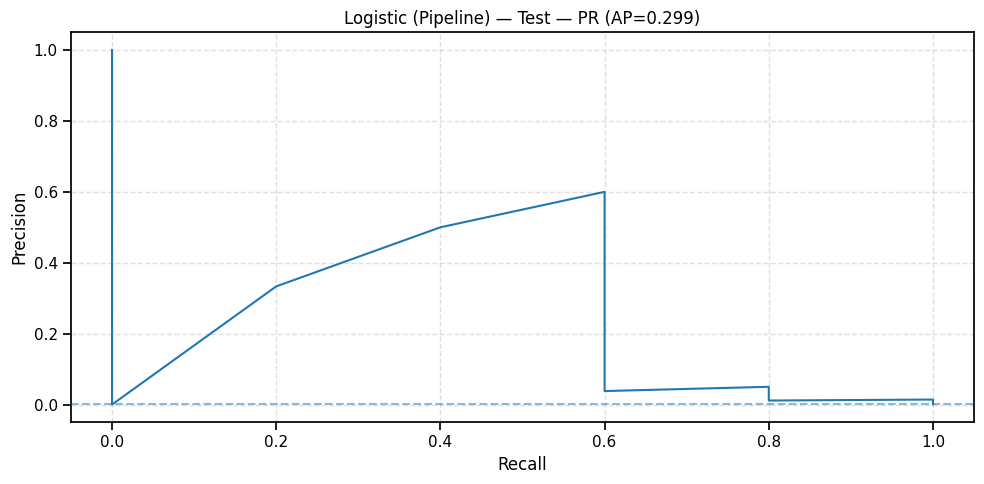

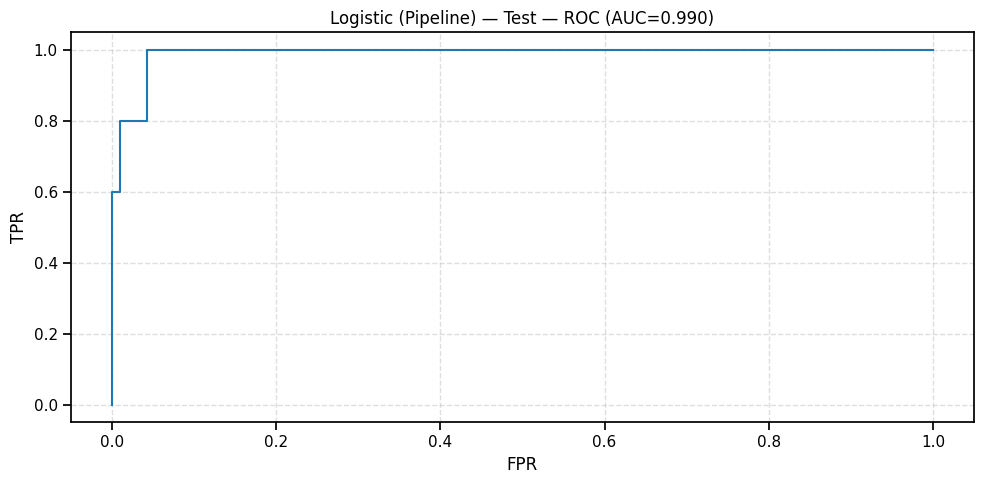

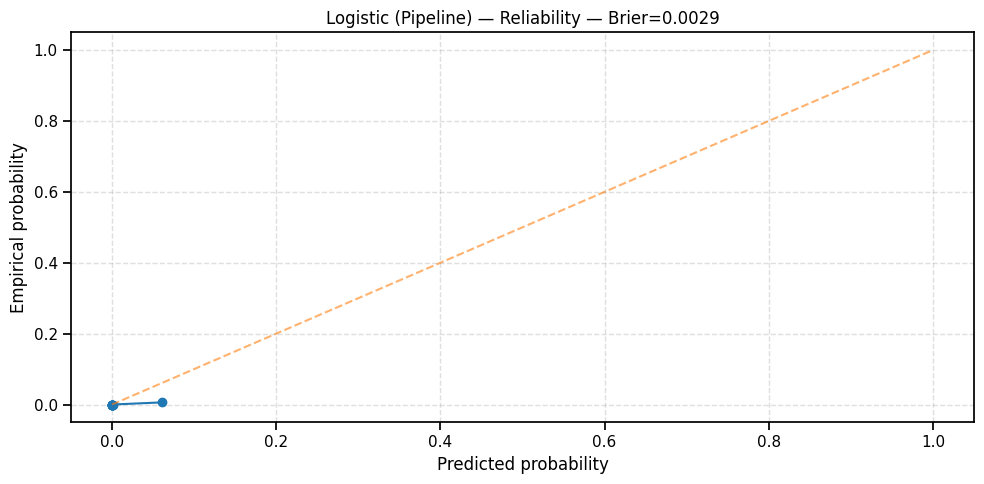

[Logistic|Pipeline] VAL AUPRC: 0.7787372189650272
[Logistic|Pipeline] TEST AUPRC: 0.2994756554307116


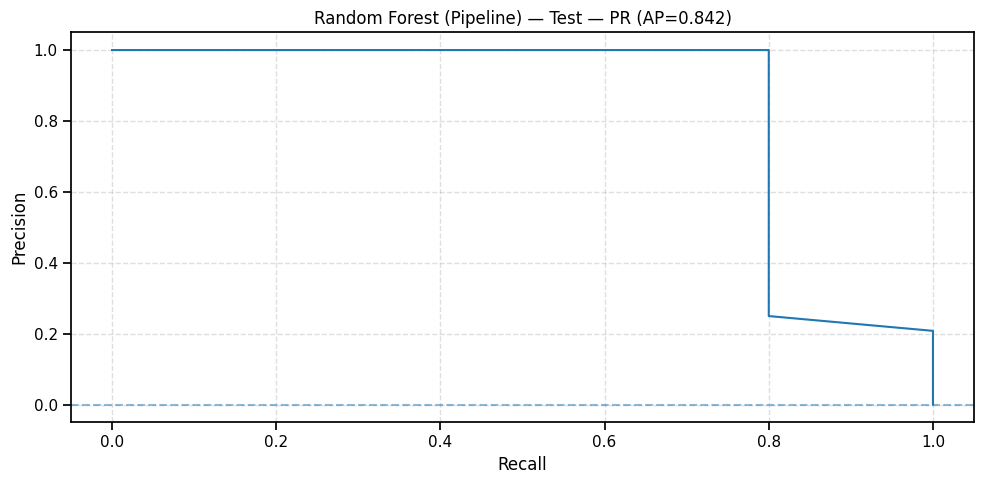

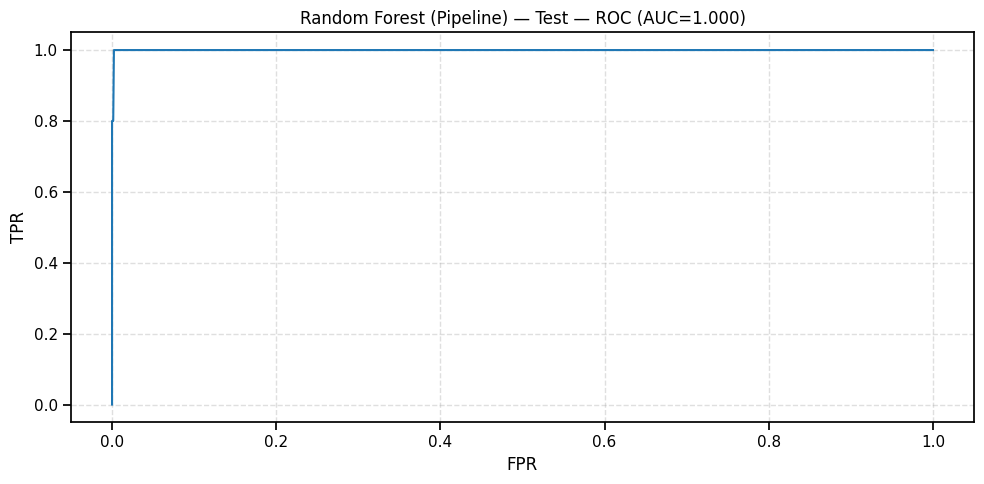

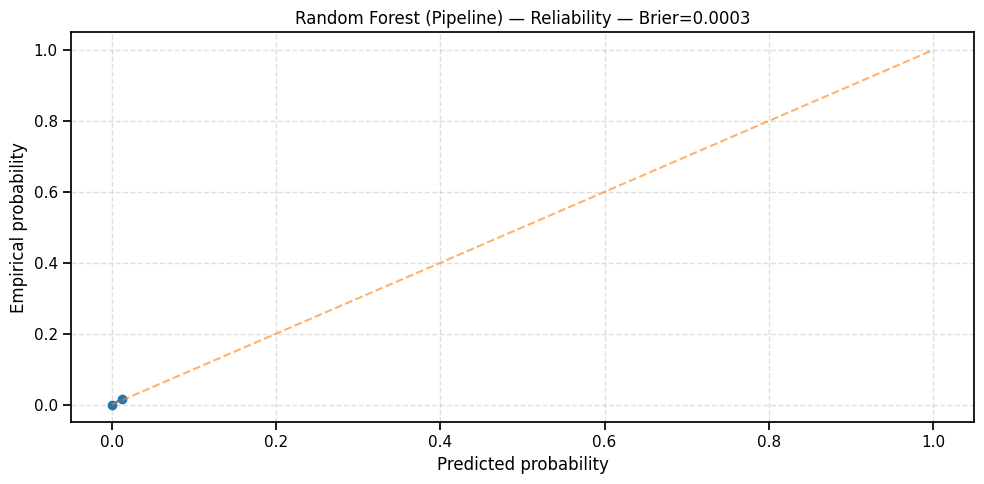

[RF|Pipeline] VAL AUPRC: 0.8862617135207496
[RF|Pipeline] TEST AUPRC: 0.8416666666666668


In [29]:

# Logistic Regression
logit_pipe = ImbPipeline(steps=[
    ("scaler", StandardScaler(with_mean=True)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=SEED))
])
logit_pipe.fit(X_train, y_train)

val_log_proba  = logit_pipe.predict_proba(X_val)[:, 1]
test_log_proba = logit_pipe.predict_proba(X_test)[:, 1]


plot_pr_roc(y_test, test_log_proba, "Logistic (Pipeline) — Test")
reliability_plot(y_test, test_log_proba, "Logistic (Pipeline) — Reliability")
print("[Logistic|Pipeline] VAL AUPRC:",  average_precision_score(y_val , val_log_proba))
print("[Logistic|Pipeline] TEST AUPRC:", average_precision_score(y_test, test_log_proba))

# Random Forest
rf_pipe = ImbPipeline(steps=[
    ("clf", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=SEED,
        n_jobs=-1
    ))
])
rf_pipe.fit(X_train, y_train)

val_rf_proba  = rf_pipe.predict_proba(X_val)[:, 1]
test_rf_proba = rf_pipe.predict_proba(X_test)[:, 1]


plot_pr_roc(y_test, test_rf_proba, "Random Forest (Pipeline) — Test")
reliability_plot(y_test, test_rf_proba, "Random Forest (Pipeline) — Reliability")
print("[RF|Pipeline] VAL AUPRC:",  average_precision_score(y_val , val_rf_proba))
print("[RF|Pipeline] TEST AUPRC:", average_precision_score(y_test, test_rf_proba))

Overlay PR Curves

In [32]:
def plot_pr_overlay(y_true, preds_dict, title="PR Curves — Overlay"):
    plt.figure(figsize=(8,6))
    base = y_true.mean()
    plt.axhline(base, ls="--", alpha=0.5, label=f"Baseline (prevalence={base:.4f})")

    for name, y_prob in preds_dict.items():
        ps, rs, _ = precision_recall_curve(y_true, y_prob)
        ap = average_precision_score(y_true, y_prob)
        plt.plot(rs, ps, label=f"{name} (AP={ap:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.grid(True, ls="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

